# TD5: Solving the advection equation with finite-difference methods

The goal of this TD is to solve the following advection equation with finite-difference methods:
$$
    \begin{cases}
        \displaystyle{\frac{\partial u}{\partial t} + V \frac{\partial u}{\partial x} = 0} \text{ with } (t,x)\in\mathbb{R}_*^+\times]-L, L[ \\
        u (t, x + 2L) = u (t, x) \text { with } (t,x) \in \mathbb{R}_*^+\times[-L, L] \\
        u (0, x) = u_0 (x) \text{ with } x \in [-L, L]
   \end{cases}
$$
Given an initial function $u_0$, a uniform velocity field $V$ and periodic boundary conditions on the 1D spatial domain $[-L,L]$, we want to solve the advection equation using **three different numerical schemes**: an explicit centered scheme, the Lax-Friedrichs scheme and the Lax-Wendroff scheme. We will focus on the **stability analysis** of these schemes and on some **unwanted numerical behaviors** that stem from them.

We will note $\Delta t$ and $\Delta x$ the time step and the spatial step respectively. For a given numerical solution $u (t,x)$, $u_j^n$ will refer to the computed value $u (t_n, x_j)$ where $(t_n, x_j) = (n\Delta t, -L + j\Delta x)$. With $N = 2L / \Delta x$, periodic boundary conditions read: $\forall n, u_{j+N}^n = u_j^n$. In practice we will be interested in computing the solution at a given time $T$.

We will need in the following the usual Python packages:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import functools 
import operator 

We can use the following values of the parameters (but of course we are free to use other values in this TD!):

In [2]:
L = 4.0
V = 1.0
T = 1.0

We will test our codes with the initial function $u_0(x) = \max(0, 1-|x|)$:

In [3]:
def u0(x):
    return np.maximum(0, 1 - np.abs(x))

## Part 0: Stability notions

In this part we recall a few notions concerning the **stability of a numerical scheme**.

### Definition of the stability of a linear numerical scheme

For a given numerical solution $u(t,x)$, we will note $u^n = (u_j^n)_{0\leq j < N}$ the vector in $\mathbb{R}^n$ space of the computed values of the solution at a time $t_n$. A linear (one-step) scheme implies the existence of a matrix $A$ of shape $N\times N$ such as:
$$
    \forall n\in \mathbb{N}, u^{n+1} = A u^n
$$
Hence, we have (be careful: although there have similar notations, $n$ is an index in the left hand side while $n$ is a power in the right-hand side):
$$
    \forall n\in \mathbb{N}, u^n = A^n u^0
$$

From a numerical point of view, what we **DO NOT** want is **divergence**! Thus, for a given norm $||\text{ . }||$ in $\mathbb{R}^N$, we will say a linear scheme is stable if and only if there exists $K > 0$ independent of $\Delta t$ and $\Delta x$ such as: $\forall n\in \mathbb{N}, ||A^n||\leq K$ (where the matrix norm is the norm induced from $\mathbb{R}^n$ norm $||\text{ . }||$). A stable scheme would then satisfy: $\forall n\in \mathbb{N}, ||u^n|| \leq K||u^0||$, meaning no divergence!

### Von Neumann stability analysis

For the specific case of $L^2$ norm stability, we can reason in Fourier space: this is called **Von Neumann stability analysis**. We will admit and apply the following method:
1. We write $u_j^n = z^ne^{ikx_j}$ (with $z \in \mathbb{C}$ playing the role of a Fourier amplification factor for a given mode $k$)
2. We inject the previous expression in the numerical scheme equation.
3. The numerical scheme will be stable (in $L^2$ norm) if and only if: $\forall k, |z| \leq 1$.

The aim of Von Neumann stability analysis is therefore to find some conditions on the numerical parameters ($\Delta t, \Delta x, V, ...$) so that $\forall k, |z| \leq 1$.

## Part 1: An explicit centered scheme

In this part, we will work on the following **explicit centered scheme**:
$$
    \frac{u_j^{n+1} - u_j^n}{\Delta t} + V\frac{u_{j+1}^n - u_{j-1}^n}{2\Delta x} = 0
$$

**1)** Numerically solve the advection equation using this explicit centered scheme on the spatial domain $[-L, L]$. We will plot on the same figure the initial function $u_0$ and the values of the solution at the time $T$. We can choose several values of $\Delta t$ and $\Delta x$.

In [4]:
def circ_shift(l, i):
    return np.append(l[i:], l[:i])

In [10]:
def create_scheme(form):
    '''
    form should be an array containing the prefactors in front of unj, un(j-1), un(j_1)
    the algorithm will assume that the array will be ordered symmetrically so:
    un(j - k), un(j- k + 1), ..., un(j-1), unj, un(j+1), ..., un(j+k-1), un(j+k)
    '''
    def step(un, form):
        k = int((len(form)-1)/2)
        out = un.copy()
        out *= form[k]
        for i in range(1, k+1):
            out += (form[i-1] * circ_shift(un, -i) + form[-i] * circ_shift(un, i))
        return out
    
    return (lambda un : step(un, form))
    

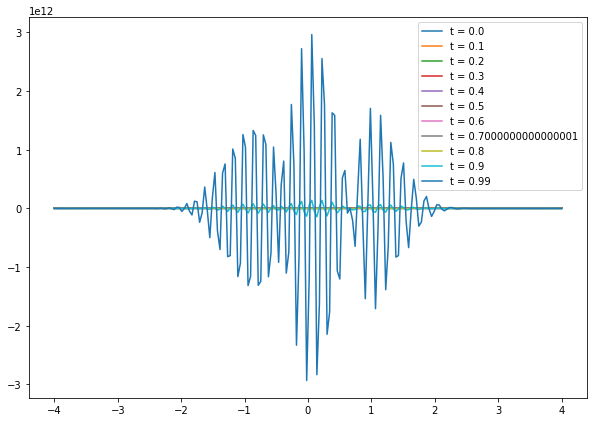

In [11]:
def solve_scheme(formGen, dt, dx, evol = True, evolStep = 10):
    Nt, Nx = int(T/dt), int(L/(dx*2))

    form = formGen(dt, dx)
    step = create_scheme(form)

    x = np.linspace(-L, L, Nx)
    uInit = u0(x)

    un = uInit

    plt.figure(figsize=(10, 7))
    
    for i in range(Nt):
        un = step(un)
        if i%evolStep == 0 and evol:
            plt.plot(x, un, label = 't = {}'.format(i*dt))

    plt.plot(x, un, label = 't = {}'.format(i*dt))
    plt.legend()
    plt.show()
    

solve_scheme(lambda dt, dx : [ V*dt/(2*dx), 1,  -V*dt/(2*dx) ], 1e-2, 1e-2)

You should have observed the unstability of this scheme.

**2)** Show through a **Von Neumann stability analysis** that this scheme is unconditionally unstable.

## Part 2: The Lax-Friedrichs scheme: a diffusive scheme

In this part, we will work on the **Lax-Friedrichs scheme** which is defined as follows:
$$
    \frac{2u_j^{n+1} - u_{j+1}^n - u_{j-1}^n}{2\Delta t} + V\frac{u_{j+1}^n - u_{j-1}^n}{2\Delta x} = 0
$$

**3)** Is this scheme stable? We will perform a **Von Neumann stability analysis** of this scheme and show that this scheme is stable if the following CFL condition is respected:
$$
    |V|\Delta t \leq \Delta x
$$

**4)** Numerically solve the advection equation using the Lax-Friedrichs scheme on the spatial domain $[-L, L]$. We will first choose values of $V, \Delta t$ and $\Delta x$ that meet the previous CFL condition, then we will try values that do not meet this condition to observe an unstability.

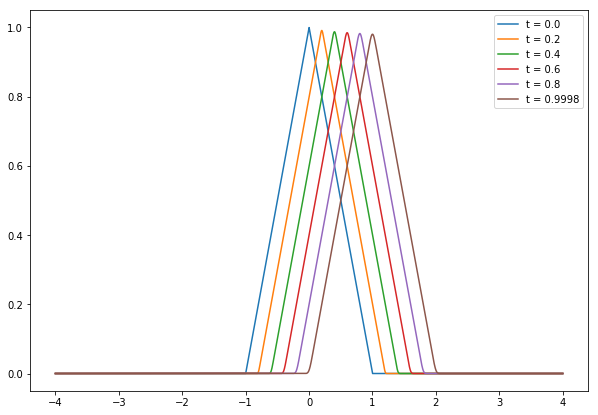

In [35]:
dt, dx = 2*1e-4, 1e-4

solve_scheme(lambda dx, dt : [ (dx + dt * V)/(2*dx), 0, (dx - dt*V)/(2*dx) ], dt, dx, True, 1000)

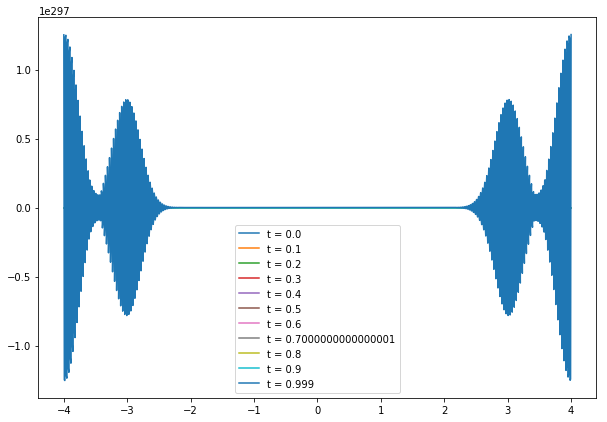

In [36]:
dt, dx = 1e-3, 2*1e-3

solve_scheme(lambda dx, dt : [ (dx + dt * V)/(2*dx), 0, (dx - dt*V)/(2*dx) ], dt, dx, True, 100)

**5)** Perform a **Taylor expansion** of the Lax-Friedrichs scheme around a point $(t_n, x_j)$ for an exact solution of the advection equation $u(t,x)$ to the first non-vanishing order. We should get (when the CFL condition is verified):
$$
    \frac{2u (t_{n+1}, x_j) - u (t_{n}, x_{j+1}) - u (t_{n}, x_{j-1})}{2\Delta t} + V\frac{u (t_{n}, x_{j+1}) - u (t_{n}, x_{j-1})}{2\Delta x} = - \frac{(\Delta x)^2}{2\Delta t}\left(1-\frac{(V\Delta t)^2}{(\Delta x)^2}\right)\frac{\partial^2u}{\partial x^2}(t_n, x_j) + \mathcal{O}\left((\Delta x)^2 + \frac{(\Delta x)^4}{\Delta t}\right)
$$


This shows that the Lax-Friedrichs scheme is also a good approximation of the following convection-diffusion equation:
$$
    \frac{\partial u}{\partial t} + V \frac{\partial u}{\partial x} - \nu \frac{\partial^2u}{\partial x^2} = 0 \text{ with } \nu = \frac{(\Delta x)^2}{2\Delta t}\left(1-\frac{(V\Delta t)^2}{(\Delta x)^2}\right)
$$
The third term of this equation corresponds to a diffusive term, where $\nu$ plays the role of a diffusion coefficient. This scheme is therefore a **diffusive scheme**.

**6)** Choosing values of $V, \Delta t$ and $\Delta x$ so that $\nu$ is big enough, observe this diffusive behaviour of the Lax-Friedrichs scheme.

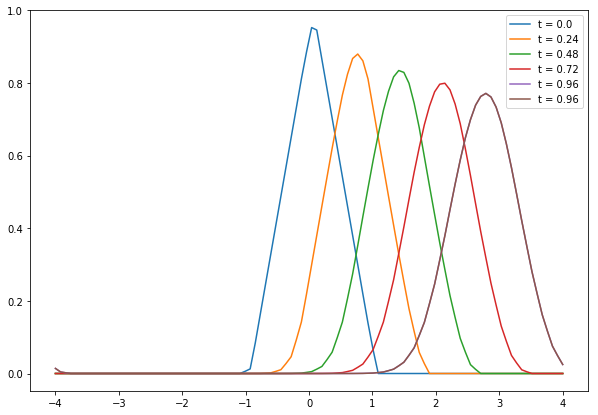

In [31]:
dx, dt = 0.02, 1.2*0.02

solve_scheme(lambda dx, dt : [ (dx + dt * V)/(2*dx), 0, (dx - dt*V)/(2*dx) ], dt, dx, True)

## Part 3: The Lax-Wendroff scheme: a dispersive scheme

In this part, we will work on the **Lax-Wendroff scheme** which is defined as follows:
$$
    \frac{u_j^{n+1} - u_j^n}{\Delta t} + V\frac{u_{j+1}^n - u_{j-1}^n}{2\Delta x} - \left(\frac{V^2\Delta t}{2}\right)\frac{u_{j-1}^n - 2u_j^n + u_{j+1}^n}{(\Delta x)^2} = 0
$$

**7)** Perform a **Von Neumann stability analysis** of this scheme and exhibit a CFL condition for its stability.

**8)** Numerically solve the Lax-Wendroff scheme on the spatial domain $[-L, L]$ showing at least one stable behavior and one unstable behavior.

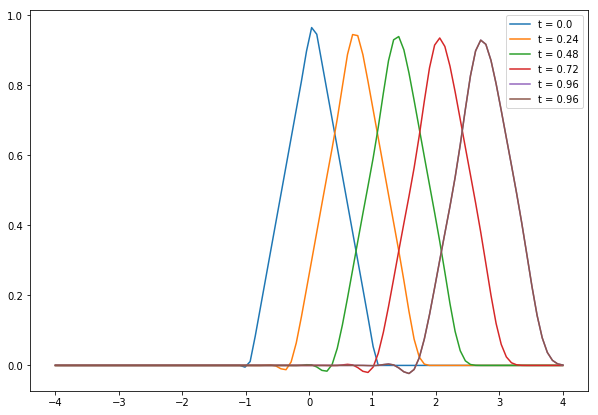

In [33]:
dx, dt = 0.02, 1.2*0.02

solve_scheme(lambda dx, dt : [ (dt * dx * V + dt**2 * V**2)/(2 * dx**2),
                              (2 * dx**2 - 2 * dt**2 * V**2)/(2 * dx**2),
                              (dt**2 * V**2 - dt * dx * V)/(2 * dx**2)], dt, dx, True)

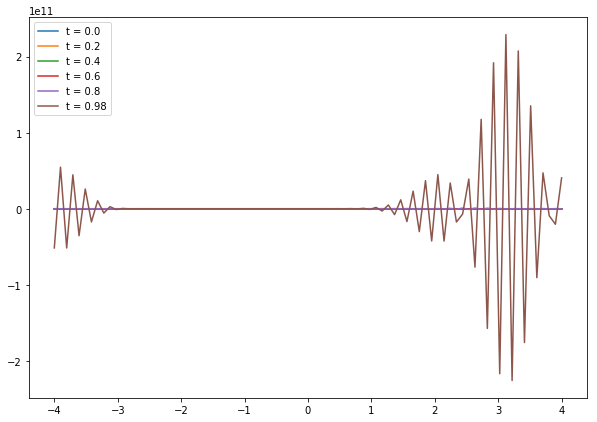

In [34]:
dt, dx = 0.02, 1.2*0.02

solve_scheme(lambda dx, dt : [ (dt * dx * V + dt**2 * V**2)/(2 * dx**2),
                              (2 * dx**2 - 2 * dt**2 * V**2)/(2 * dx**2),
                              (dt**2 * V**2 - dt * dx * V)/(2 * dx**2)], dt, dx, True)

**9)** Perform a **Taylor expansion** of the Lax-Wendroff scheme around a point $(t_n, x_n)$ for an exact solution of the advection equation $u(t,x)$ to the first non-vanishing order. We should get (when the CFL condition is verified):
$$
    \frac{u (t_{n+1}, x_j) - u (t_{n}, x_{j})}{\Delta t} + V\frac{u (t_{n}, x_{j+1}) - u (t_{n}, x_{j-1})}{2\Delta x} - \left(\frac{V^2\Delta t}{2}\right)\frac{u (t_{n}, x_{j-1}) - 2u (t_{n}, x_{j}) + u (t_{n}, x_{j+1})}{(\Delta x)^2} = \frac{V\Delta x^2}{6}\left(1-\frac{(V\Delta t)^2}{\Delta x^2}\right)\frac{\partial^3u}{\partial x^3}(t_n, x_j) + \mathcal{O}(\Delta t^3 + \Delta x^3)
$$

This shows that the Lax-Wendroff scheme is also a good approximation of the following equation:
$$
    \frac{\partial u}{\partial t} + V \frac{\partial u}{\partial x} + \frac{V(\Delta x)^2}{6}\left(1 - \frac{(V\Delta t)^2}{(\Delta x)^2}\right)\frac{\partial^3u}{\partial x^3} = 0
$$
The third term of this equation corresponds to a dispersive term. This scheme is therefore a **dispersive scheme**.

**10)** Choosing values of $V, \Delta t$ and $\Delta x$ so that the dispersive term can be big enough, observe this dispersive behaviour of the Lax-Wendroff scheme.

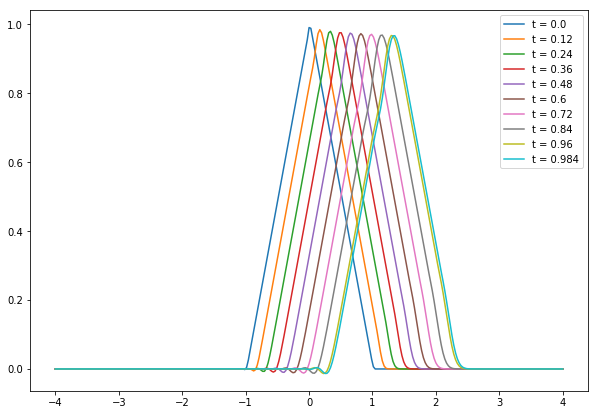

In [62]:
dx, dt = 0.007, 0.012

solve_scheme(lambda dx, dt : [ (dt * dx * V + dt**2 * V**2)/(2 * dx**2),
                              (2 * dx**2 - 2 * dt**2 * V**2)/(2 * dx**2),
                              (dt**2 * V**2 - dt * dx * V)/(2 * dx**2)], dt, dx, True)


